### Data source:   
https://finances.worldbank.org/Projects/IFC-Advisory-Services-Projects/b74b-t2z3

In [224]:
# importing libraries
import pandas as pd
import requests
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import squarify
from scipy import stats

%matplotlib inline

In [225]:
# loading data

url = 'https://finances.worldbank.org/resource/b74b-t2z3.json'
response = requests.get(url)

data = response.json()
df = pd.DataFrame(data)

In [226]:
df.head()

,disclosure_date,project_number,project_name,project_url,country,ifc_country_code,region,business_line,estimated_total_budget,status,projected_start_date,country_code,as_of_date,ifc_approval_date
0,2023-03-16T00:00:00.000,605676,Uganda Grain Development Project - Agilis,{'url': 'https://disclosures.ifc.org/project-d...,Uganda,UAN,Eastern Africa,"Manufacturing, Agribusiness & Services",999900,Active,2022-03-01T00:00:00.000,UG,2023-04-07T02:05:00.000,NaN
1,2023-03-15T00:00:00.000,606574,Integrated ESG Project for Bangladesh,{'url': 'https://disclosures.ifc.org/project-d...,Bangladesh,BAN,South Asia,"Environment, Social and Governance",535000,Active,2022-05-09T00:00:00.000,BD,2023-04-07T02:05:00.000,2022-05-09T00:00:00.000
2,2023-03-14T00:00:00.000,604142,Accelerating Innovations & Disruptive Technolo...,{'url': 'https://disclosures.ifc.org/project-d...,India,IND,South Asia,Other,1192018,Active,NaN,IN,2023-04-07T02:05:00.000,2022-06-16T00:00:00.000
3,2023-03-14T00:00:00.000,607145,Inclusive Health Nephroplus,{'url': 'https://disclosures.ifc.org/project-d...,India,IND,South Asia,"Environment, Social and Governance",90000,Active,2022-08-11T00:00:00.000,IN,2023-04-07T02:05:00.000,2022-08-11T00:00:00.000
4,2023-03-01T00:00:00.000,607305,mKopa eMobility,{'url': 'https://disclosures.ifc.org/project-d...,Kenya,KEN,Eastern Africa,Financial Institutions Group,145000,Active,2022-07-01T00:00:00.000,KE,2023-04-07T02:05:00.000,2022-07-28T00:00:00.000


In [227]:
# removing unnecesary columns
del df['project_url']
del df['ifc_country_code']
del df['country_code']
del df['as_of_date']
del df['projected_start_date']

In [228]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   disclosure_date         1000 non-null   object
 1   project_number          1000 non-null   object
 2   project_name            1000 non-null   object
 3   country                 1000 non-null   object
 4   region                  1000 non-null   object
 5   business_line           1000 non-null   object
 6   estimated_total_budget  931 non-null    object
 7   status                  1000 non-null   object
 8   ifc_approval_date       939 non-null    object
dtypes: object(9)
memory usage: 70.4+ KB


In [229]:
df.disclosure_date = pd.to_datetime(df.disclosure_date)
df.ifc_approval_date = pd.to_datetime(df.ifc_approval_date)
df.estimated_total_budget = pd.to_numeric(df.estimated_total_budget)

df = df.dropna()

In [230]:
df = df[df.estimated_total_budget != 0]

In [231]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 873 entries, 1 to 999
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   disclosure_date         873 non-null    datetime64[ns]
 1   project_number          873 non-null    object        
 2   project_name            873 non-null    object        
 3   country                 873 non-null    object        
 4   region                  873 non-null    object        
 5   business_line           873 non-null    object        
 6   estimated_total_budget  873 non-null    float64       
 7   status                  873 non-null    object        
 8   ifc_approval_date       873 non-null    datetime64[ns]
dtypes: datetime64[ns](2), float64(1), object(6)
memory usage: 68.2+ KB


In [232]:
df.region.unique()

array(['South Asia', 'Eastern Africa', 'Central Asia and Turkiye',
       'North Africa and Horn of Africa', 'West Africa',
       'Southern Africa', 'South America', 'Middle East', 'Europe',
       'East Asia and the Pacific',
       'Central Africa, Liberia, Nigeria, and Sierra Leone',
       'Central America and the Caribbean, Colombia, Mexico',
       'Latin America and the Caribbean and Europe', 'World', 'Africa'],
      dtype=object)

In [233]:
# renaming regions
df['region'] = df['region'].replace({'Eastern Africa': 'Africa', 'Central Asia and Turkiye': 'Central Asia', \
                                    'North Africa and Horn of Africa': 'Africa', 'West Africa': 'Africa', \
                                    'Southern Africa': 'Africa', 'Central Africa, Liberia, Nigeria, and Sierra Leone': 'Africa',  \
                                    'Central America and the Caribbean, Colombia, Mexico': 'Central America', 'Latin America and the Caribbean and Europe': 'Latin America'})


In [234]:
df.region.unique()

array(['South Asia', 'Africa', 'Central Asia', 'South America',
       'Middle East', 'Europe', 'East Asia and the Pacific',
       'Central America', 'Latin America', 'World'], dtype=object)

In [235]:
# correcting dates
delta = (df['disclosure_date'] - df['ifc_approval_date']).dt.days
mask = delta < 0
df.loc[mask, 'ifc_approval_date'] = df.loc[mask, 'disclosure_date']

In [236]:
df.to_csv('ifc_projects.csv')

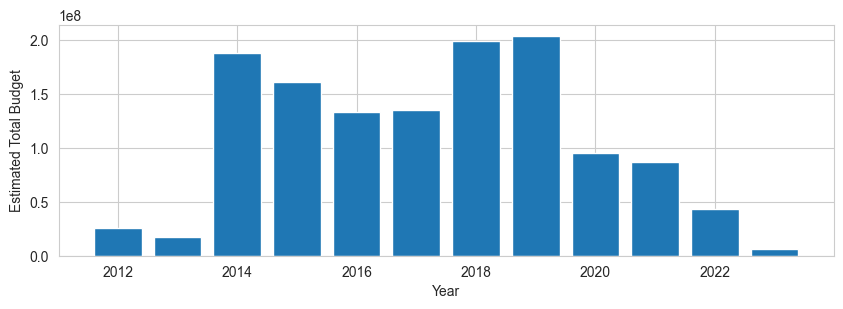

In [237]:
# plotting data

plt.figure(figsize=(10, 3))

df_grouped = df.groupby(df['ifc_approval_date'].dt.year)['estimated_total_budget'].sum()
plt.bar(df_grouped.index, df_grouped.values)
plt.xlabel('Year')
plt.ylabel('Estimated Total Budget')
ax.set_title("Total number of projects")
plt.ticklabel_format(style='sci', axis='y')

plt.show()

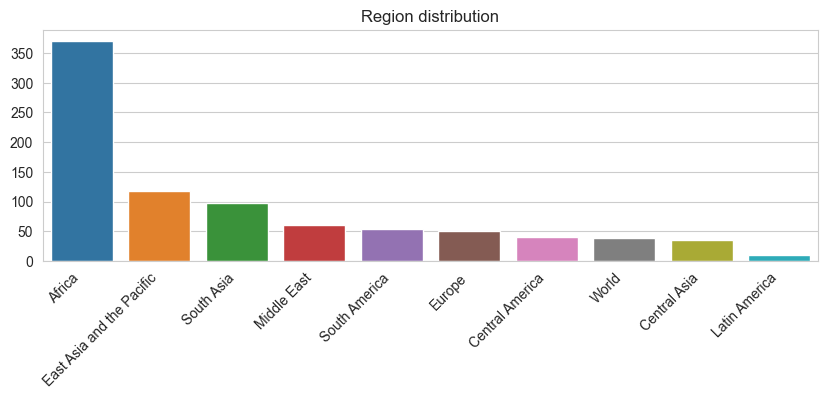

In [238]:
# plotting data

plt.figure(figsize=(10, 3))
region_counts = df['region'].value_counts().sort_values(ascending=False)
ax = sns.barplot(x=region_counts.index, y=region_counts.values, order=region_counts.index)
ax.set_title("Region distribution")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.show()

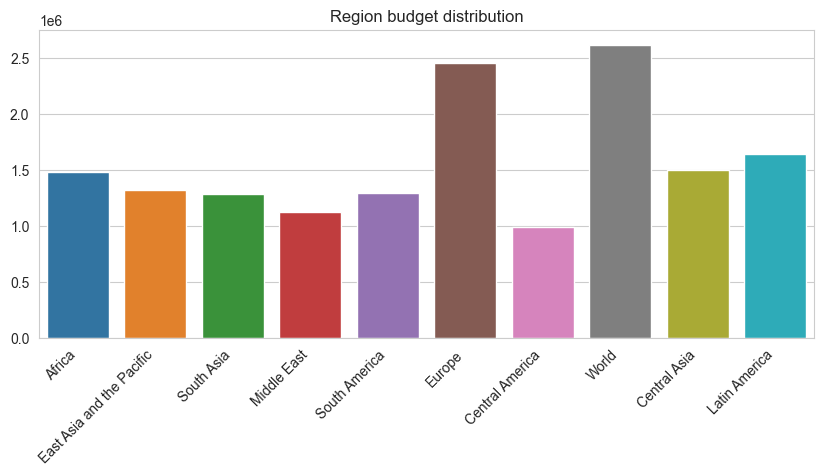

In [239]:
# plotting data

plt.figure(figsize=(10, 4))

region_counts = df['region'].value_counts().sort_values(ascending=False).index
ax = sns.barplot(x='region', y='estimated_total_budget', data=df, order=region_counts, errorbar=None)

# set title and rotate x-axis labels
ax.set_title("Region budget distribution")
ax.set(xlabel=None)
ax.set(ylabel=None)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


# display plot
plt.show()

In [240]:
df.describe()

,estimated_total_budget
count,8.730000e+02
mean,1.484414e+06
std,1.819053e+06
min,2.000000e+04
25%,4.887590e+05
50%,9.700000e+05
75%,1.970000e+06
max,2.466710e+07


### Despite Africa having a substantial number of projects globally, their total budget is comparable to the world average. On the other hand, Europe and the rest of the world have a significant amount of budget allocated to projects.

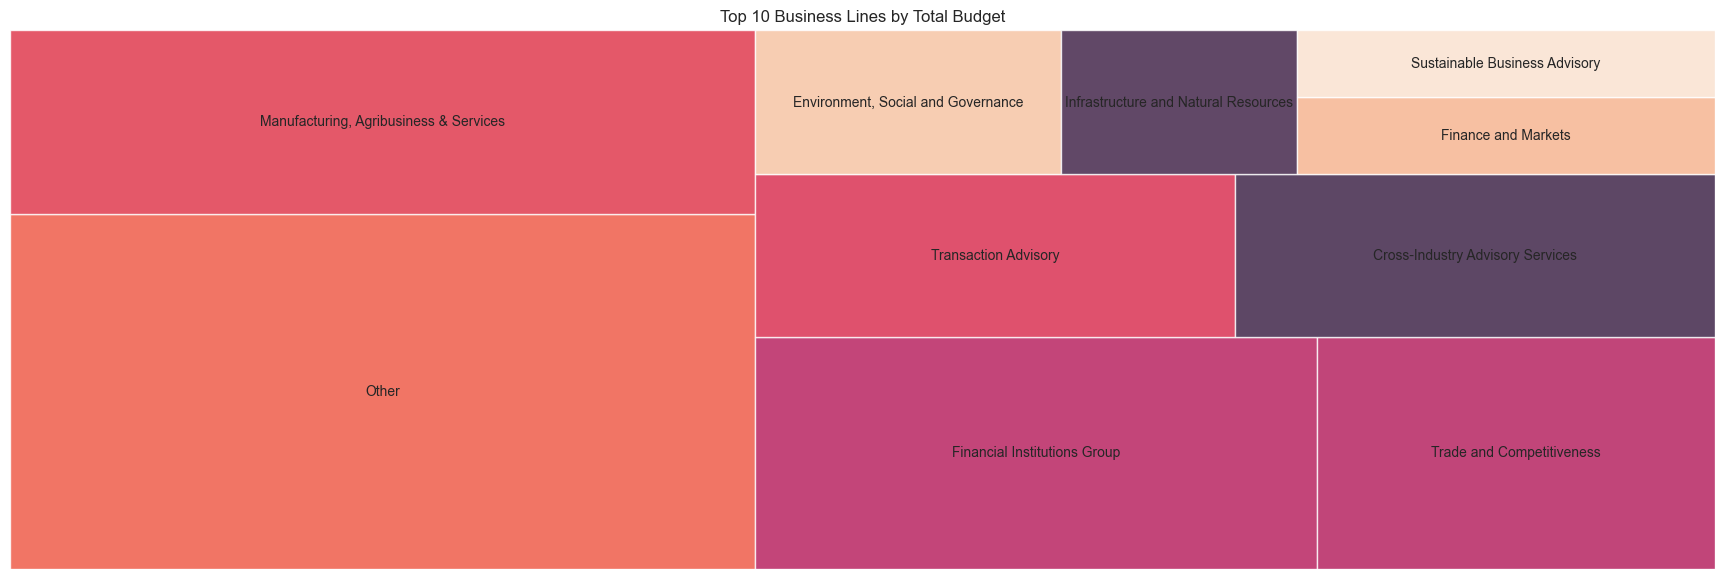

In [241]:
# Plotting Treemap for top 10 project categories

plt.figure(figsize=(22, 7))

top_bis = df.groupby('business_line')['estimated_total_budget'].sum().sort_values(ascending=False)[:10]
df_top = top_bis.reset_index().rename(columns={'index': 'column1'})
squarify.plot(sizes=df_top['estimated_total_budget'], label=df_top['business_line'], alpha=.8,)

# add labels and title
plt.axis('off')
plt.title("Top 10 Business Lines by Total Budget")

# display plot
plt.show()

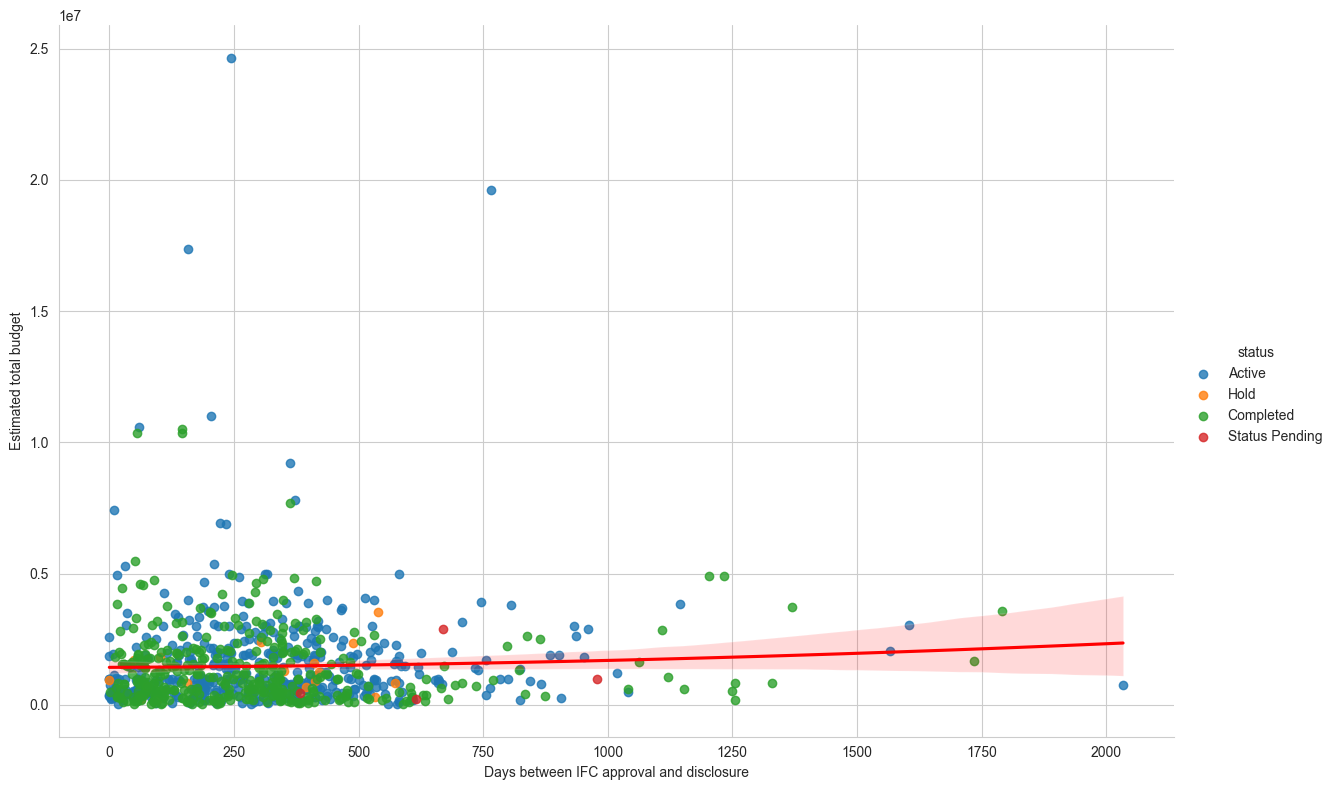

In [242]:
# plotting data

df['Appr'] = (df['disclosure_date'] - df['ifc_approval_date']).dt.days

# create the lmplot with height and aspect parameters
sns.lmplot(y='estimated_total_budget', x='Appr', data=df, height=8, aspect=1.5, hue = 'status', ci = None, fit_reg=False)
sns.regplot(y='estimated_total_budget', x='Appr', data=df, scatter=False, order = 2, color='r')
# set the x and y axis labels
plt.xlabel('Days between IFC approval and disclosure')
plt.ylabel('Estimated total budget')

# show the plot
plt.show()

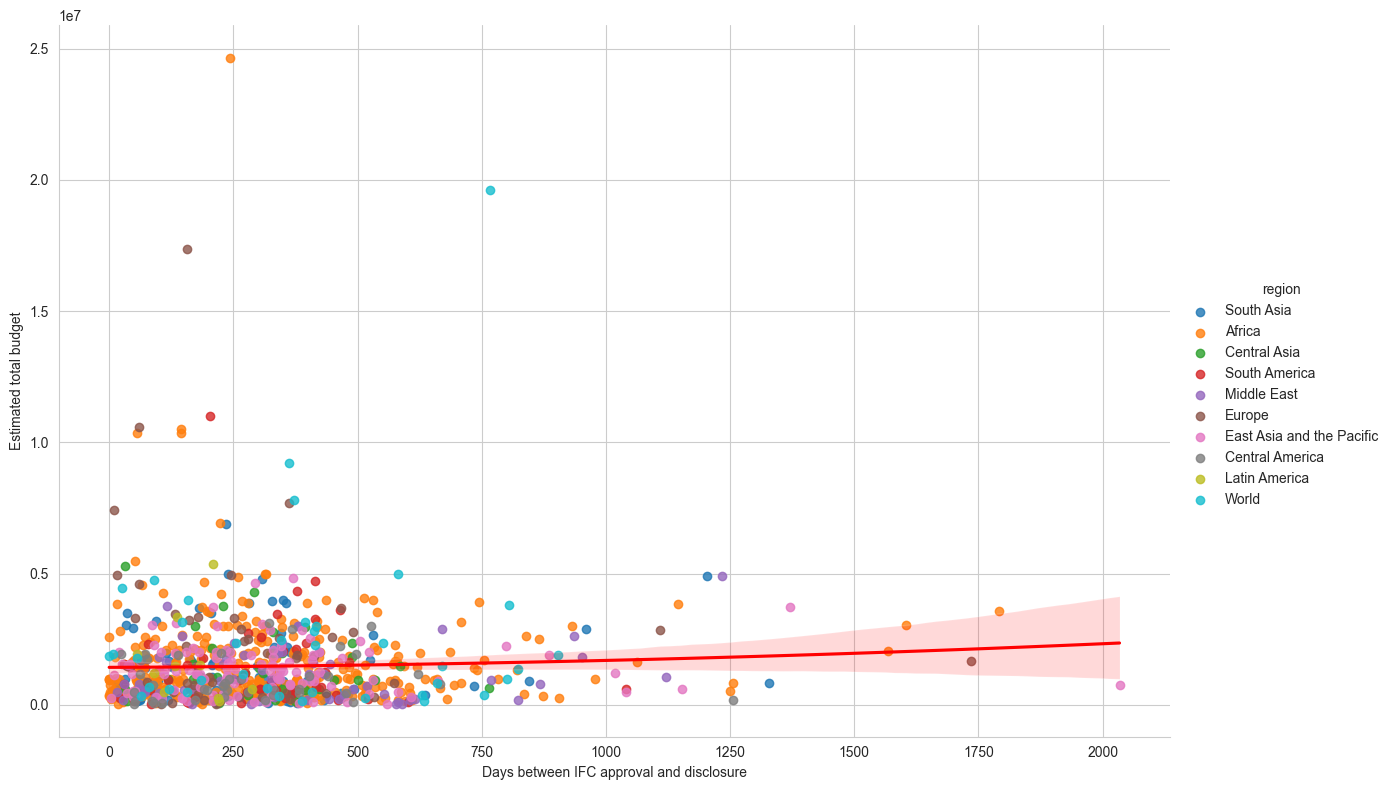

In [243]:
# plotting data

df['Appr'] = (df['disclosure_date'] - df['ifc_approval_date']).dt.days

# create the lmplot with height and aspect parameters
sns.lmplot(y='estimated_total_budget', x='Appr', data=df, height=8, aspect=1.5, hue = 'region', ci = None, fit_reg=False)
sns.regplot(y='estimated_total_budget', x='Appr', data=df, scatter=False, order = 2, color='r')
# set the x and y axis labels
plt.xlabel('Days between IFC approval and disclosure')
plt.ylabel('Estimated total budget')


# show the plot
plt.show()

In [244]:
stats.pearsonr(df.estimated_total_budget, df.Appr)

PearsonRResult(statistic=0.039855748402800574, pvalue=0.2394426731347211)

In [247]:
# Checking outliers
df[df.estimated_total_budget > 15000000]

,disclosure_date,project_number,project_name,country,region,business_line,estimated_total_budget,status,ifc_approval_date,Appr
357,2020-07-01,603725,KKCF,Kenya,Africa,"Manufacturing, Agribusiness & Services",24667100.0,Active,2019-10-31,244
512,2019-02-22,602817,Ukraine EE Fund,Ukraine,Europe,Other,17353525.0,Active,2018-09-18,157
716,2017-05-18,600795,SME Finance Forum,United States,World,Financial Institutions Group,19634638.0,Active,2015-04-13,766


In [248]:
# Checking outliers
df[df.Appr > 1500]

,disclosure_date,project_number,project_name,country,region,business_line,estimated_total_budget,status,ifc_approval_date,Appr
123,2022-04-29,601704,SMEV Advisory Project - CLMDF II,Cambodia,East Asia and the Pacific,Other,739677.0,Active,2016-10-03,2034
416,2020-01-13,600085,DRC Inv Climate,"Congo, Democratic Republic of",Africa,Other,2062709.0,Active,2015-09-29,1567
467,2019-07-04,600673,East.AfCGP,Kenya,Africa,"Environment, Social and Governance",3029007.0,Active,2015-02-10,1605
629,2018-02-21,599538,DCW-ECA CGP,Ukraine,Europe,"Environment, Social and Governance",1661479.0,Completed,2013-05-23,1735
735,2017-03-01,592948,DFS Knowledge Management,Africa Region,Africa,Financial Institutions Group,3573088.0,Completed,2012-04-05,1791
